## Background

House price has always been an serious social issue in Taiwan, especially in Taipei city. The nation-wide house price to income ratio revealed by Taiwanese government is around 8.62 in 2020(**[1]**). For Taipei city is around 14.39. If we compare these values with Demographia International Housing Affordability Survey 2019(**[2]**), it's not hard to realize that this such a high number. 

Therefore, I would like to build a regression model trying to predict the housing price in Taipei city, the capital city of Taiwan. Not only to predict the housing price, I also would like to find out what affect housing price the most influentially. Hope the analysis could give us some insight into the cause of present house price problem in Taiwan.

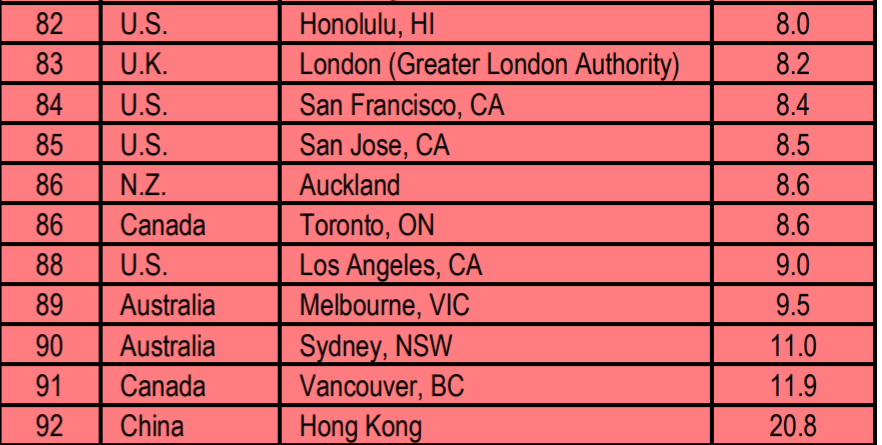

## About Dataset

 This dataset is downloaded from Kaggle(**[3]**). This dataset contains some useful information about recent real estate transaction in Taipei city, the original data mainly comes from open data of Ministry of the Interior of Taiwan(**[4]**).

#### Before importing our dataset of desired, we have to import necessary Python modules

In [270]:
import pandas as pd
import numpy as np
import csv 
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

%matplotlib inline

#### Now let's import our dataset and check the first few rows with head method.

In [271]:
#We import dataset as "Resident_Dataset" which we already filtered out other data not for resident use.
Resident_Dataset = pd.read_csv('2020_H2_Resident_ENG.csv')
Shape = Resident_Dataset.shape

#Let's see how the dataset looks like
Resident_Dataset.head()

,district,transaction type,land shifting total area,transaction year,num_building,num_land,num_garage,total floor number,building state,main building materials,complete year,building shifting total area,num_room,num_bathroom,compartment,management org,carpark type,carpark shifting area,carpark total price,main building area,subsidiary building area,balcony area,elevator,total ntd,unit ntd
0,Wenshan District,Land+Building,1261.30,108,1,3,0,1.0,House,Reinforced Concrete,NaN,245.48,0,0,0,0,No carpark,0.0,0,245.48,0.00,0.00,0,523060000,2130764
1,ZhongZheng District,Land+Building,36.00,109,1,2,0,5.0,Apartment_5storey,Reinforced Concrete,76.0,142.01,3,2,1,0,No carpark,0.0,0,106.57,4.81,16.47,0,18500000,130273
2,ZhongZheng District,Land+Building,19.39,109,1,2,0,7.0,Apartment_5to10storey,Reinforced Concrete,102.0,84.97,2,1,1,0,No carpark,0.0,0,50.17,0.00,5.05,1,21580000,253972
3,ZhongZheng District,Land+Building,10.66,109,1,1,0,5.0,Apartment_5storey,Strengthened Brickwork,NaN,34.63,0,1,1,0,No carpark,0.0,0,33.00,1.63,0.00,0,10400000,300318
4,ZhongZheng District,Land+Building,45.00,109,1,1,0,4.0,Apartment_5storey,Strengthened Brickwork,58.0,99.86,3,2,1,0,No carpark,0.0,0,99.86,0.00,0.00,0,35800000,358502


## Data Cleaning and Feature Engineering

#### In this cell, we transform some of the column into quantity per unit land or building.
#### Also, we do some feature engineering to create some new features for later analysis.

In [272]:
#We do not take transaction data with 0 room into consideration
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_room"]!=0]

In [273]:
# This part average land shifting total area with number of land transaction.
Resident_Dataset["land shifting total area per unit transaction"] = Resident_Dataset["land shifting total area"]/Resident_Dataset["num_land"]
Resident_Dataset["land shifting total area per unit transaction"].replace(np.inf, np.nan, inplace = True)
Resident_Dataset["land shifting total area per unit transaction"].fillna(0,inplace = True)

# This part average building shifting total area with number of building transaction.
Resident_Dataset["building shifting total area per unit transaction"] = Resident_Dataset["building shifting total area"]/Resident_Dataset["num_building"]

#This part average some other columns with number of building
Resident_Dataset["num_room"] = Resident_Dataset["num_room"]/Resident_Dataset["num_building"]
Resident_Dataset["num_bathroom"] = Resident_Dataset["num_bathroom"]/Resident_Dataset["num_building"]
Resident_Dataset["main building area"] = Resident_Dataset["main building area"]/Resident_Dataset["num_building"]
Resident_Dataset["balcony area"] = Resident_Dataset["balcony area"]/Resident_Dataset["num_building"]
Resident_Dataset["subsidiary building area"] = Resident_Dataset["subsidiary building area"]/Resident_Dataset["num_building"]

#This part adds some derived feature to the dataset
#This line create total shifting area per unit transaction
Resident_Dataset["total shifting area per unit transaction"] = Resident_Dataset["land shifting total area per unit transaction"] + Resident_Dataset["building shifting total area per unit transaction"]

#This line create building age at transaction
Resident_Dataset["building age at transaction"] = Resident_Dataset['transaction year'] - Resident_Dataset['complete year']

#This line create main building ratio by taking main building area over building shifting total area
Resident_Dataset["main building ratio"] = Resident_Dataset["main building area"]/Resident_Dataset["building shifting total area"]

#This line create unit price without carpark price included
Resident_Dataset["unit ntd nocarpark"] = (Resident_Dataset["total ntd"] - Resident_Dataset["carpark total price"])/Resident_Dataset["building shifting total area"]


#Finally, we drop some columns that is no longer of our interest
Resident_Dataset.drop(columns=["carpark total price","num_garage","carpark shifting area","carpark type","land shifting total area","building shifting total area","num_land","num_building","transaction year","complete year","total ntd","unit ntd"], inplace = True)
Resident_Dataset.head()

,district,transaction type,total floor number,building state,main building materials,num_room,num_bathroom,compartment,management org,main building area,subsidiary building area,balcony area,elevator,land shifting total area per unit transaction,building shifting total area per unit transaction,total shifting area per unit transaction,building age at transaction,main building ratio,unit ntd nocarpark
1,ZhongZheng District,Land+Building,5.0,Apartment_5storey,Reinforced Concrete,3.0,2.0,1,0,106.57,4.81,16.47,0,18.000,142.01,160.010,33.0,0.750440,130272.516020
2,ZhongZheng District,Land+Building,7.0,Apartment_5to10storey,Reinforced Concrete,2.0,1.0,1,0,50.17,0.00,5.05,1,9.695,84.97,94.665,7.0,0.590444,253971.990114
4,ZhongZheng District,Land+Building,4.0,Apartment_5storey,Strengthened Brickwork,3.0,2.0,1,0,99.86,0.00,0.00,0,45.000,99.86,144.860,51.0,1.000000,358501.902664
6,Wanhua District,Land+Building+Garage,24.0,Apartment_11storeyorgreater,Reinforced Concrete,1.0,1.0,1,1,33.95,3.15,3.22,1,4.460,97.18,101.640,1.0,0.349352,122967.688825
7,Wanhua District,Land+Building+Garage,24.0,Apartment_11storeyorgreater,Reinforced Concrete,2.0,1.0,1,1,35.45,2.61,3.75,1,4.570,75.59,80.160,1.0,0.468977,160074.083874


In [274]:
#According to common sense, it is abnormal for a single building to have more than 6 rooms and bathrooms
#Thus we filter out data not within this range.
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_room"] <= 6]
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_bathroom"] <= 6]

#### In this cell, we check if there are duplicated rows and found that there are 48 duplicated rows

In [275]:
#We use duplicated method to find out duplicated rows and print our results
num_duplicated = sum(Resident_Dataset.duplicated(keep = "first"))
print("There are " + str(num_duplicated) + " duplicated rows in this dataset")

#Then, we update our dataset to no duplicate one
Resident_Dataset = Resident_Dataset[~Resident_Dataset.duplicated(keep = "first")]
display(Resident_Dataset.head())

#Check again to see if there are duplicates
num_duplicated = sum(Resident_Dataset.duplicated(keep = "first"))
print("There are " + str(num_duplicated) + " duplicated rows in this dataset after cleaning")

There are 44 duplicated rows in this dataset


,district,transaction type,total floor number,building state,main building materials,num_room,num_bathroom,compartment,management org,main building area,subsidiary building area,balcony area,elevator,land shifting total area per unit transaction,building shifting total area per unit transaction,total shifting area per unit transaction,building age at transaction,main building ratio,unit ntd nocarpark
1,ZhongZheng District,Land+Building,5.0,Apartment_5storey,Reinforced Concrete,3.0,2.0,1,0,106.57,4.81,16.47,0,18.000,142.01,160.010,33.0,0.750440,130272.516020
2,ZhongZheng District,Land+Building,7.0,Apartment_5to10storey,Reinforced Concrete,2.0,1.0,1,0,50.17,0.00,5.05,1,9.695,84.97,94.665,7.0,0.590444,253971.990114
4,ZhongZheng District,Land+Building,4.0,Apartment_5storey,Strengthened Brickwork,3.0,2.0,1,0,99.86,0.00,0.00,0,45.000,99.86,144.860,51.0,1.000000,358501.902664
6,Wanhua District,Land+Building+Garage,24.0,Apartment_11storeyorgreater,Reinforced Concrete,1.0,1.0,1,1,33.95,3.15,3.22,1,4.460,97.18,101.640,1.0,0.349352,122967.688825
7,Wanhua District,Land+Building+Garage,24.0,Apartment_11storeyorgreater,Reinforced Concrete,2.0,1.0,1,1,35.45,2.61,3.75,1,4.570,75.59,80.160,1.0,0.468977,160074.083874


There are 0 duplicated rows in this dataset after cleaning


#### Then, we check if there is NaN or Null values
Result shows there are only 3 columns are with NaN or Null value, and proportion of it are all less than 1%

In [276]:
#We build a dataframe to exhibit the percentage of NaN or Null value 
NAN_Rate = pd.DataFrame(data={"% of NAN":Resident_Dataset.isna().sum()/Shape[0]})
NAN_Rate[NAN_Rate["% of NAN"]!=0]

,% of NAN
total floor number,0.001427
main building materials,0.000204
building age at transaction,0.058494


#### Subsequently, we remove those rows with NaN or Null since it only occupies less than 1 % of the dataset

In [277]:
for cols in list(Resident_Dataset.columns):
    Resident_Dataset = Resident_Dataset[~Resident_Dataset[cols].isna()]

print("Shape of Resident_Dataset is now " + str(Resident_Dataset.shape))

Shape of Resident_Dataset is now (8431, 19)


#### Now, we would first observe the distribution of numerical variables

First extract numerical columns from original dataset based on column data type. In this step, we also abandoned some numerical columns that is considered discrete and non-quatitative variable. There are 12 different numerical features in our dataset. 

In [278]:
#We create a table listing data types of all columns 
#and pick up numerical ones based on their data type
Type_Table = pd.DataFrame(data={"dtype":Resident_Dataset.dtypes})
Numerical_Columns = list(Type_Table[Type_Table["dtype"] != "object"].index)

#Remove column management_org in numerical cloumns because it's dummy variable type numerical
#Remove transaction year,month and complete year because they are discrete and non-quatitative variables
try:
    Numerical_Columns.remove("management org")
    Numerical_Columns.remove("elevator")
    Numerical_Columns.remove("unit ntd nocarpark")
    Numerical_Columns.remove("compartment")
except:
    pass

#Report results of numerical columns
print("We have " + str(len(Numerical_Columns))+" numerical features.")
print("Numerical Columns are :\n" + str(Numerical_Columns))

We have 11 numerical features.
Numerical Columns are :
['total floor number', 'num_room', 'num_bathroom', 'main building area', 'subsidiary building area', 'balcony area', 'land shifting total area per unit transaction', 'building shifting total area per unit transaction', 'total shifting area per unit transaction', 'building age at transaction', 'main building ratio']


Second, we visualize the distribution of numerical variables using histogram. \
You can see there are a lot of right skewed distribution.

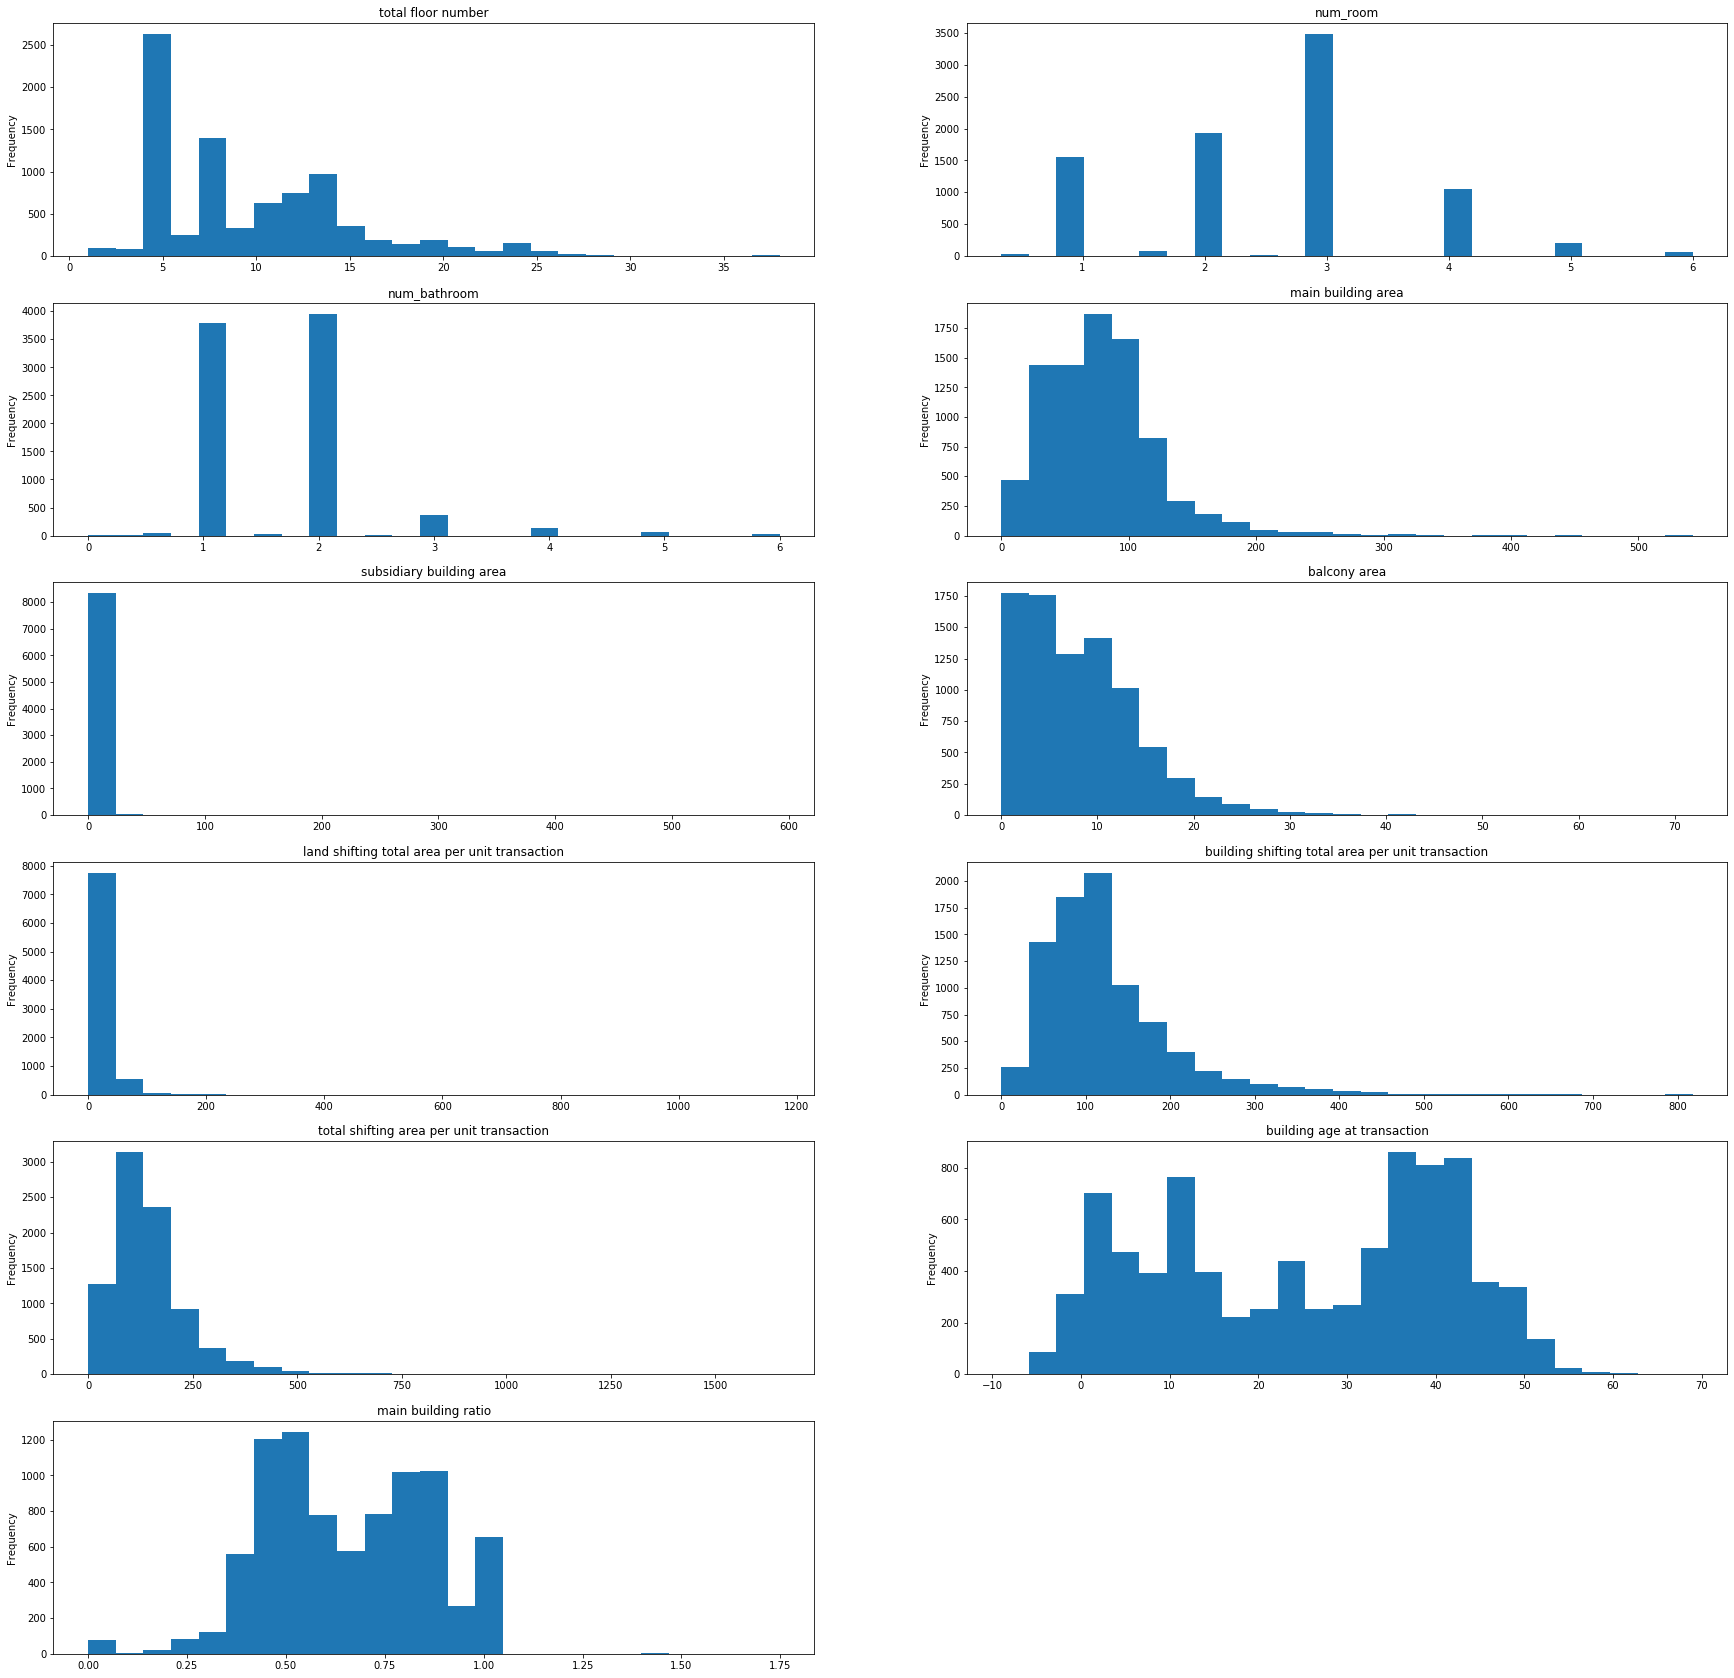

In [279]:
fig = plt.figure(figsize = [30,30])
sub_ind = 1
for cols in Numerical_Columns:
    Resident_Dataset[cols].plot.hist(ax = plt.subplot(6,2,sub_ind), bins =25, title = cols)
    sub_ind += 1

#### This cell creates a  statistical table listing 6 standard deviation and 1.5IQR information. We will reference the table to eliminate data points that is not considered normal condition at all.

In [280]:
Num_Max = []
Num_min = []
mean_lst = []
stdlist = []
stdup = []
stdlow = []
IQRup = []
IQRlow = []
for cols in Numerical_Columns:
    mean = Resident_Dataset[cols].mean()
    std = Resident_Dataset[cols].std()
    Q1 = Resident_Dataset[cols].quantile(0.25)
    Q3 = Resident_Dataset[cols].quantile(0.75)
    mean_lst.append(mean)
    stdlist.append(std)
    stdup.append(mean + 3*std)
    stdlow.append(mean - 3*std)
    IQR = Q3 - Q1
    Num_Max.append(Resident_Dataset[cols].max())
    Num_min.append(Resident_Dataset[cols].min())
    IQRup.append(Q3 + 1.5*IQR)
    IQRlow.append(Q1 - 1.5*IQR)

Numerical_Columns_Stats = pd.DataFrame({"Feature":Numerical_Columns,"Max":Num_Max,"min":Num_min,"Mean":mean_lst,"std":stdlist ,"IQRup":IQRup,"IQRlow":IQRlow})#,"stdup":stdup,"stdlow":stdlow})
Numerical_Columns_Stats.index = Numerical_Columns_Stats["Feature"]
Numerical_Columns_Stats.drop(columns = ["Feature"], inplace = True)
Numerical_Columns_Stats

,Max,min,Mean,std,IQRup,IQRlow
Feature,,,,,,
total floor number,38.000000,1.000000,9.575377,5.390821,25.000000,-7.000000
num_room,6.000000,0.333333,2.576029,1.064401,4.500000,0.500000
num_bathroom,6.000000,0.000000,1.642292,0.741390,3.500000,-0.500000
main building area,542.670000,0.000000,77.984741,43.735594,179.722500,-34.177500
subsidiary building area,592.210000,0.000000,2.934326,9.742213,8.175000,-4.905000
balcony area,71.870000,0.000000,8.048316,6.457355,24.155000,-9.085000
land shifting total area per unit transaction,1171.000000,0.000000,23.554676,27.023410,62.225000,-22.295000
building shifting total area per unit transaction,818.030000,0.010000,124.139421,78.890556,270.712500,-43.107500
total shifting area per unit transaction,1654.010000,0.010000,147.694097,93.957503,313.862500,-43.797500


#### We scan through numerical rows and cut off data point with value greater than limitation defined by 1.5IQR method.

In [281]:
clean_columns = ["main building area", "subsidiary building area", "balcony area",\
                "land shifting total area per unit transaction", "building shifting total area per unit transaction",\
                 "total shifting area per unit transaction"]
for cols in clean_columns:
    threshold = Numerical_Columns_Stats.loc[cols,"IQRup"]
    Resident_Dataset = Resident_Dataset[Resident_Dataset[cols] < threshold]

Resident_Dataset.shape

(7081, 19)

#### In this cell, we further clean the dataset according to our prediction goal (unit ntd nocarpark)
We would like to remove some extreme data of unit_ntd column because these values may not reflect normal housing t
transaction behavior compared to those inside our range of interest.

We will apply 1.5\*IQR method filter our data. After filtration, you can see the close to symmetry distribution of unit ntd nocarpark

Text(0.5, 1.0, 'Distribution of Unit ntd after cutting 2% data')

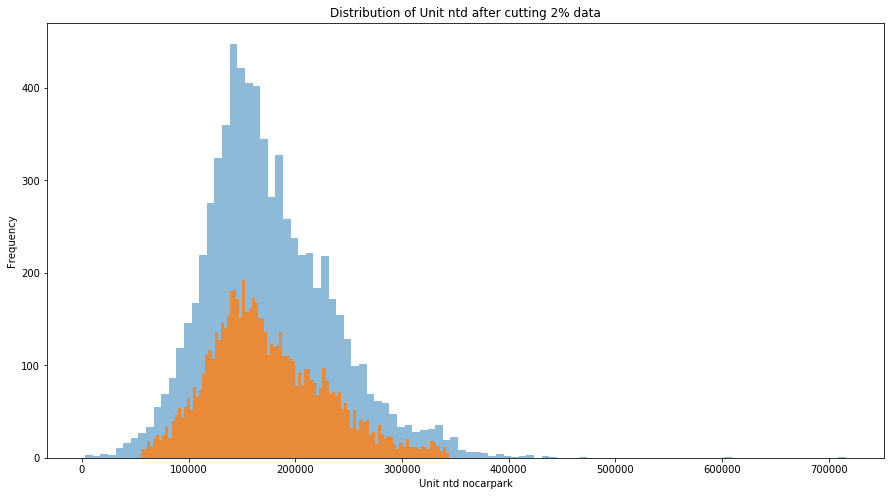

In [282]:
#In order to get a more general model that can fit non-extreme cases,
#We will abandon first and last 1% of data after sorting with unit ntd.
old_unit_ntd = Resident_Dataset["unit ntd nocarpark"]
percent_1 = Resident_Dataset.shape[0]*0.01
Resident_Dataset = Resident_Dataset.sort_values(by=['unit ntd nocarpark']).iloc[int(percent_1):-int(percent_1),:]

plt.figure(figsize = [15,8])
plt.hist(old_unit_ntd, bins = 100,alpha=0.5)
plt.hist(Resident_Dataset["unit ntd nocarpark"], bins = 100, alpha = 0.8)
plt.xlabel("Unit ntd nocarpark")
plt.ylabel("Frequency")
plt.title("Distribution of Unit ntd after cutting 2% data")


## Feature Selection

#### We first select features for our numerical dataset
Before that, we import necessary libraries for later regression

In [283]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV,RFE
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### This cell creates table for numerical variables

In [284]:
#Create numerical table

Numerical_Table = Resident_Dataset[Numerical_Columns]
Numerical_Table.head()

,total floor number,num_room,num_bathroom,main building area,subsidiary building area,balcony area,land shifting total area per unit transaction,building shifting total area per unit transaction,total shifting area per unit transaction,building age at transaction,main building ratio
2086,9.0,3.0,1.0,46.95,0.00,4.25,29.27,77.57,106.84,22.0,0.605260
6416,4.0,3.0,1.0,101.17,0.00,0.00,34.25,101.17,135.42,44.0,1.000000
3927,4.0,3.0,2.0,85.80,0.00,15.34,37.01,101.14,138.15,40.0,0.848329
7931,14.0,4.0,2.0,38.85,1.04,4.28,13.84,79.80,93.64,9.0,0.486842
1064,4.0,3.0,1.0,42.76,0.00,0.00,0.00,42.76,42.76,50.0,1.000000


,unit ntd nocarpark
unit ntd nocarpark,1.000000
building age at transaction,0.278416
total floor number,0.267731
num_room,0.217436
land shifting total area per unit transaction,0.208754
main building ratio,0.193586
main building area,0.128053
subsidiary building area,0.098225
balcony area,0.097670
num_bathroom,0.086896


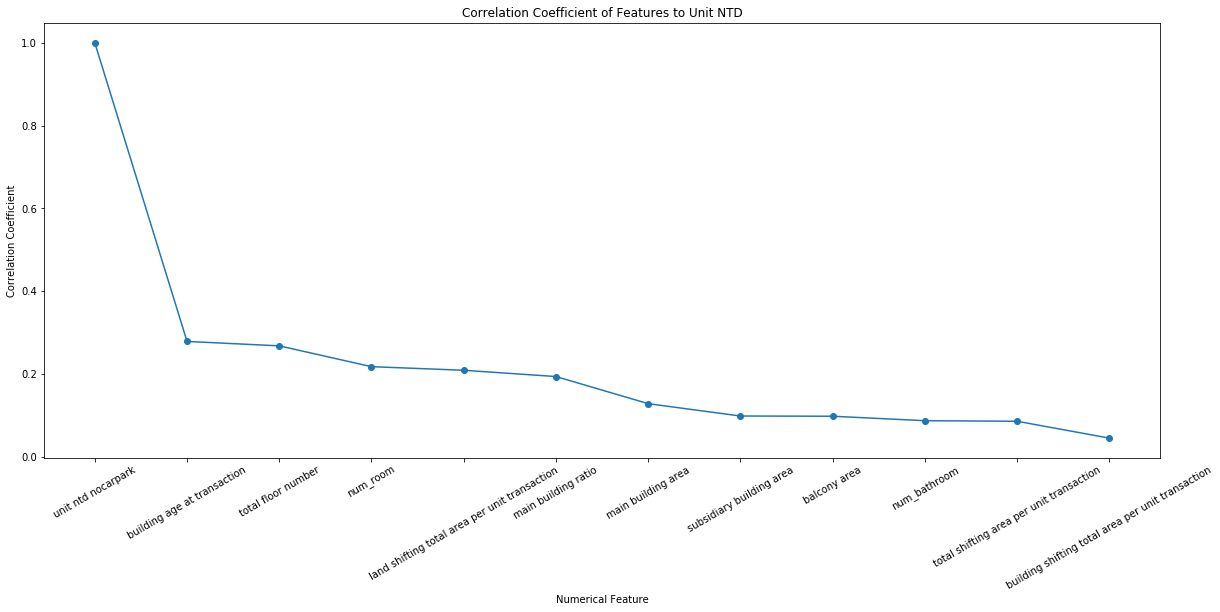

In [286]:
Numerical_Table2 = pd.concat([Numerical_Table,Resident_Dataset["unit ntd nocarpark"]],axis=1)
Numerical_Corr = pd.DataFrame(abs(Numerical_Table2.corr()["unit ntd nocarpark"])).sort_values(by="unit ntd nocarpark",ascending=False)

display(Numerical_Corr)


plt.figure(figsize = [20,8])
plt.xticks(rotation = 30)
plt.xlabel("Numerical Feature")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Coefficient of Features to Unit NTD")
plt.plot(Numerical_Corr, marker = 'o') 

Numerical_Columns2 = list(Numerical_Corr[Numerical_Corr["unit ntd nocarpark"]>0.15].index)
Numerical_Columns2.remove("unit ntd nocarpark")

del Numerical_Table2

#### We then convert categorical data into dummy variables
Before this, we first briefly inspect the number of different categories in each categorical variable.

In [287]:
Categorical_Unique = {"Categorical_Variable":[],"Unique_Values":[]}
Categorical_Columns = []
for cols in list(Resident_Dataset.columns):
    if cols not in Numerical_Columns and cols != "unit ntd nocarpark":
        Categorical_Columns.append(cols)
        Categorical_Unique["Categorical_Variable"].append(cols)
        Categorical_Unique["Unique_Values"].append(len(Resident_Dataset[cols].unique()))
Categorical_Unique_Table = pd.DataFrame(Categorical_Unique)
Categorical_Unique_Table

,Categorical_Variable,Unique_Values
0,district,12
1,transaction type,3
2,building state,8
3,main building materials,9
4,compartment,1
5,management org,2
6,elevator,2


#### Before turning these variables into dummy variable, we look briefly at the number of unique labels within  the variable

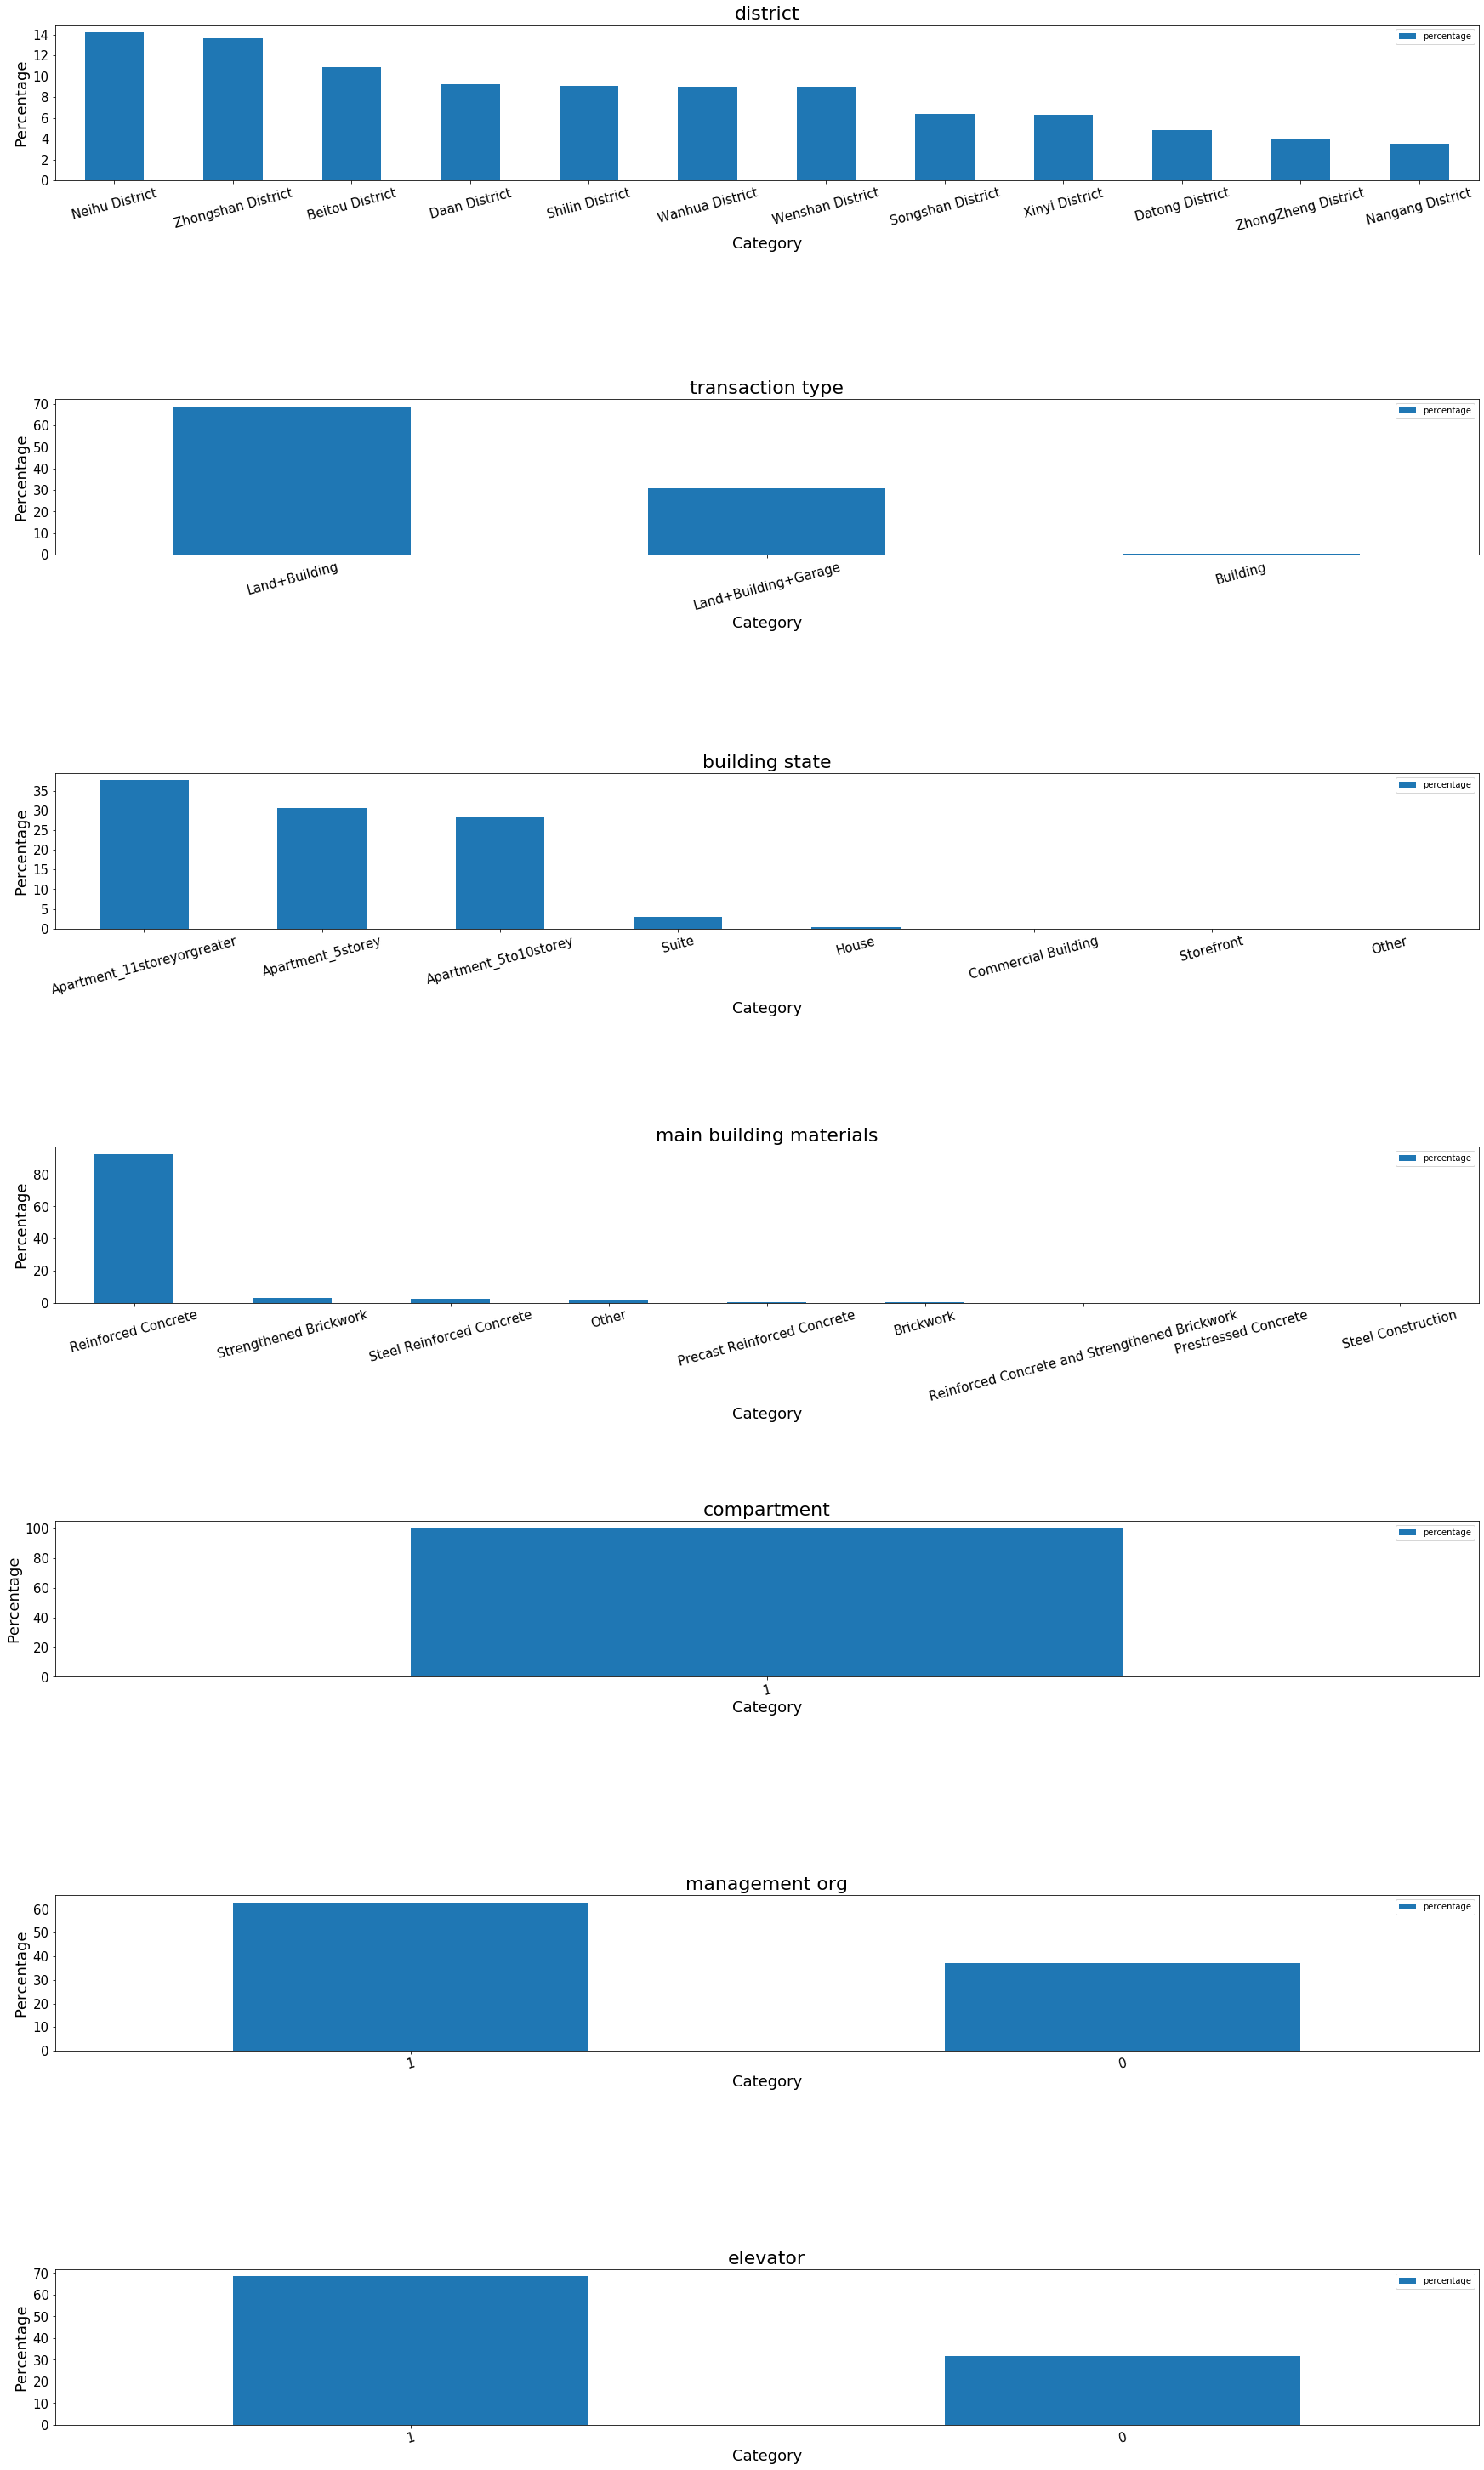

In [288]:
data_num = Resident_Dataset.shape[0]
fig2,ax2 = plt.subplots(figsize = [30,60])   
ind = 1

Proportion_Dict = {}
   
for var in Categorical_Columns:
    Temp_DF = pd.DataFrame(Resident_Dataset[var].value_counts()).reset_index()
    Temp_DF.insert(0,"variable",[var]*Temp_DF.shape[0])
    Temp_DF.columns = ["variable","category","percentage"]
    Temp_DF["percentage"] = Temp_DF["percentage"]/data_num*100
    Temp_DF.set_index(["variable","category"],inplace=True)
    for cats in list(Resident_Dataset[var].unique()):
        if var not in Proportion_Dict.keys():
            Proportion_Dict[var] = {}
        Proportion_Dict[var][cats] = Temp_DF.loc[var,cats]
        
    Temp_DF.loc[var].plot(kind="bar", ax = plt.subplot(15,1,ind),title=var,fontsize=15)
    plt.xticks(rotation=15)
    plt.xlabel("Category",fontsize = 18)
    plt.ylabel("Percentage",fontsize = 18)
    plt.title(var,fontsize=22)
    ind+=2


In [291]:
#In this cell, we will do some feature engineering on categories in features having too few samples. 
#Because this kind of transformation cannot provide effective behavior and may harm the regression 
#algorithm  

#Create a new dataset to store data for later regression
Categorical_Dataset = pd.DataFrame()

#For feature transaction_type, we will omit the category "building" and "garage" because they 
#occupied only a very minor part. Also, the concept of these two types are as well exhibited by 
#categories.
exclusion = ["management org","elevator","compartment"]
for var in Categorical_Columns:
    if var not in exclusion:
        Categorical_Dataset = pd.concat([Categorical_Dataset,pd.get_dummies(Resident_Dataset[var],prefix = var)], axis = 1, sort = False)
        for cats in Proportion_Dict[var].keys():
            value = float(Proportion_Dict[var][cats])
            if value < 1:
                Categorical_Dataset.drop(columns = [str(var) + "_" + str(cats)], inplace = True)
    else:
        Categorical_Dataset[var] = Resident_Dataset[var]
Categorical_Dataset.drop(columns=["compartment"],inplace=True)   
Categorical_Dataset

,district_Beitou District,district_Daan District,district_Datong District,district_Nangang District,district_Neihu District,district_Shilin District,district_Songshan District,district_Wanhua District,district_Wenshan District,district_Xinyi District,district_ZhongZheng District,district_Zhongshan District,transaction type_Land+Building,transaction type_Land+Building+Garage,building state_Apartment_11storeyorgreater,building state_Apartment_5storey,building state_Apartment_5to10storey,building state_Suite,main building materials_Other,main building materials_Reinforced Concrete,main building materials_Steel Reinforced Concrete,main building materials_Strengthened Brickwork,management org,elevator
2086,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1
6416,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
3927,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
7931,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1
1064,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1
3107,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1
8997,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1
3971,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1


#### Finally, we concatenate categorical and numerical dataset as our final dataset for regression

In [310]:
Dataset = pd.concat([Categorical_Dataset,Resident_Dataset[Numerical_Columns2]], axis = 1)
Dataset.head(5)

,district_Beitou District,district_Daan District,district_Datong District,district_Nangang District,district_Neihu District,district_Shilin District,district_Songshan District,district_Wanhua District,district_Wenshan District,district_Xinyi District,district_ZhongZheng District,district_Zhongshan District,transaction type_Land+Building,transaction type_Land+Building+Garage,building state_Apartment_11storeyorgreater,building state_Apartment_5storey,building state_Apartment_5to10storey,building state_Suite,main building materials_Other,main building materials_Reinforced Concrete,main building materials_Steel Reinforced Concrete,main building materials_Strengthened Brickwork,management org,elevator,building age at transaction,total floor number,num_room,land shifting total area per unit transaction,main building ratio
2086,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,22.0,9.0,3.0,29.27,0.605260
6416,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,44.0,4.0,3.0,34.25,1.000000
3927,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,40.0,4.0,3.0,37.01,0.848329
7931,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,9.0,14.0,4.0,13.84,0.486842
1064,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,50.0,4.0,3.0,0.00,1.000000


#### The last step, we perform VIF(variance_inflation_factor) analysis to reduce the affect of colinearity to our predictive model

In [311]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Retrieve initial column list
column = list(Dataset.columns)
Temp_Dataset = Dataset.copy()

#Iterate until all VIFs are less than 10(typical value)
VIF_safe = False

while VIF_safe == False:
    vif_table = pd.DataFrame()
    vif_table["Features"] = column
    vif_table["VIF"] = [variance_inflation_factor(Temp_Dataset.values, i) for i in range(Temp_Dataset.shape[1])]
 
    #Handle inf values
    if sum(vif_table["VIF"] == np.inf) >0:
        column.remove(list(vif_table[vif_table["VIF"] == np.inf]["Features"])[0])
        Temp_Dataset = Temp_Dataset[column]
        
    #Handle VIF greater than 10
    elif sum(vif_table["VIF"] > 10) > 0:
        vif_table.sort_values(by=["VIF"], ascending = False, inplace = True)
        column.remove(list(vif_table["Features"])[0])
        Temp_Dataset = Temp_Dataset[column]
        
    #All VIFs are less than 10, set VIF_safe = True
    else: 
        VIF_safe = True
    
#delete Temp_Numerical_Table
del Temp_Dataset

#Assign numerical columns to the result after VIF analysis
Dataset = Dataset[column]

display(vif_table)

,Features,VIF
0,district_Beitou District,1.739047
1,district_Daan District,1.806623
2,district_Datong District,1.336917
3,district_Nangang District,1.233034
4,district_Shilin District,1.631284
5,district_Songshan District,1.502260
6,district_Wanhua District,1.748209
7,district_Wenshan District,1.589750
8,district_Xinyi District,1.452593
9,district_ZhongZheng District,1.261459


## Regression

#### We first divide our dataset into training and test set using train_test_split method in Scikit-Learn. Then, we apply Ordinary Least Square (OLS) method in statsmodel.api module and remove some features with higher P value (indicating that the feature is possibly not significant)

In [327]:
#import statsmodel.api module
import statsmodels.api as sm
from  sklearn.metrics import r2_score

#Adding intercept term for dataset
Dataset["intercept"] = 1

#Divide whole dataset into x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(Dataset,Resident_Dataset["unit ntd nocarpark"],test_size=0.3,random_state = 0)

#Fit the data with ordinary least square method
LR_OLS = sm.OLS(y_train, x_train)
LR_OLS_result = LR_OLS.fit()
LR_OLS_result.summary()
#We try to remove data column with relatively high p value to see if we can get better result(threshold 0.01)
P_table = pd.DataFrame(LR_OLS_result.pvalues)
P_table.columns = ["P value"]
Dataset = Dataset[P_table[P_table["P value"]<0.05].index]

In [328]:
Metrics_Table = pd.DataFrame(index = ["LR_OLS_TRAIN","LR_OLS_TEST","LR_OLS_R1","LR_OLS_R2","LR_OLS_R3","LR_OLS_R4","LR_OLS_R5"],\
                             columns = ["R squared", "RMSE"])

Metrics_Table.loc["LR_OLS_TRAIN","R squared"] = LR_OLS_result.rsquared
Metrics_Table.loc["LR_OLS_TEST","R squared"] = r2_score(y_test,LR_OLS_result.predict(x_test))
Metrics_Table.loc["LR_OLS_TRAIN","RMSE"] = np.sqrt(mean_squared_error(LR_OLS_result.predict(x_train),y_train))
Metrics_Table.loc["LR_OLS_TEST","RMSE"] = np.sqrt(mean_squared_error(LR_OLS_result.predict(x_test),y_test))

Coef_Table = pd.DataFrame(index = list(Dataset.columns))

In [329]:
for i in range(1,6):
    x_train1, x_test1, y_train1, y_test1 = train_test_split(Dataset, Resident_Dataset["unit ntd nocarpark"], test_size=0.3, random_state = i)
    LR_OLS2 = sm.OLS(y_train1, x_train1)
    LR_OLS2_result = LR_OLS2.fit()
    Metrics_Table.loc["LR_OLS_R" + str(i), "R squared"] = LR_OLS2_result.rsquared
    Metrics_Table.loc["LR_OLS_R" + str(i), "RMSE"] = np.sqrt(mean_squared_error(LR_OLS2_result.predict(x_test1),y_test1))
    Coef_Table["LR_OLS_R" + str(i) + "_Coef"] = list(LR_OLS2_result.params)

In [331]:
Coef_Table["LR_OLS_AVG"] = Coef_Table.mean(axis = 1)
Coef_Table

,LR_OLS_R1_Coef,LR_OLS_R2_Coef,LR_OLS_R3_Coef,LR_OLS_R4_Coef,LR_OLS_R5_Coef,LR_OLS_AVG
district_Beitou District,-26693.113374,-26778.742274,-28963.582222,-26246.956458,-27853.838643,-27307.246594
district_Daan District,75834.376235,73527.566515,76057.183573,77319.253456,74989.945034,75545.664963
district_Songshan District,52781.576055,51084.263950,48949.200324,50509.980338,50535.644894,50772.133112
district_Wanhua District,-32872.605731,-35106.810228,-33048.685968,-32781.179302,-32766.172327,-33315.090711
district_Wenshan District,-27794.809647,-27813.725872,-27204.996508,-28218.813452,-26855.460456,-27577.561187
district_Xinyi District,34799.983112,34343.801986,32427.081585,32058.616370,34483.172751,33622.531161
district_ZhongZheng District,44604.162741,44342.230336,45696.979769,43547.302012,44315.859456,44501.306863
district_Zhongshan District,22394.439568,22446.793286,20486.233988,21584.544030,20205.416774,21423.485529
transaction type_Land+Building+Garage,-26399.382384,-27012.746173,-27870.289643,-25674.421583,-27543.434511,-26900.054859
building state_Apartment_5storey,-19815.739926,-22727.992517,-18483.036255,-19598.212736,-22839.772047,-20692.950696


In [330]:
Metrics_Table

,R squared,RMSE
LR_OLS_TRAIN,0.523317,38061.1
LR_OLS_TEST,0.560996,36486.1
LR_OLS_R1,0.528283,35702.6
LR_OLS_R2,0.541355,38986.7
LR_OLS_R3,0.536631,37371
LR_OLS_R4,0.527968,38032.2
LR_OLS_R5,0.529788,37424


In [ ]:
#Divide whole dataset after RFECV into x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(Dataset,Resident_Dataset["unit ntd nocarpark"],test_size=0.25,random_state = 1)

#We run 
LR = LinearRegression(fit_intercept = True, normalize = True)
LR.fit(x_train,y_train)
y_test_pred = LR.predict(x_test)
LR.score(x_test,y_test)

Summary = pd.DataFrame({"Metrics":["R square","RMSE"],"Value":[LR.score(x_test,y_test),np.sqrt(mean_squared_error(y_test,y_test_pred))]})
display(Summary)


In [ ]:
def RMSE(data1,data2):
    data1=np.array(data1).reshape(data1.shape[0],1)
    data2=np.array(data2).reshape(data2.shape[0],1)
    return np.sqrt(np.sum((data1-data2)**2)/data1.shape[0])

LR1 = LinearRegression(fit_intercept = True, normalize = True)
LR1.fit(x_train1,y_train1)
y_test_pred1 = LR1.predict(x_test1)
pd.DataFrame({"y_test":y_test1,"y_test_predict":y_test_pred1})
LR1.score(x_test1,y_test1)
RMSE(y_test1,y_test_pred1)

#### We then use iterative gradient descent to do the linear regression

## Reference
1. https://pip.moi.gov.tw/V3/E/SCRE0105.aspx
2. http://www.demographia.com/dhi.pdf
3. https://www.kaggle.com/chrischien17/taiwan-taipei-city-real-estate-transaction-records
4. https://plvr.land.moi.gov.tw/DownloadOpenData

In [253]:
pd.options.display.max_columns = 50
display(Resident_Dataset[Resident_Dataset["num_bathroom"] >= 6])

,district,transaction type,total floor number,building state,main building materials,num_room,num_bathroom,compartment,management org,main building area,subsidiary building area,balcony area,elevator,land shifting total area per unit transaction,building shifting total area per unit transaction,total shifting area per unit transaction,building age at transaction,main building ratio,unit ntd nocarpark
210,Neihu District,Land+Building+Garage,16.0,Apartment_11storeyorgreater,Reinforced Concrete,6.0,6.0,1,1,117.00,5.98,0.00,1,25.640000,182.56,208.200000,25.0,0.640885,136941.279579
274,Xinyi District,Land+Building,5.0,Apartment_5storey,Reinforced Concrete,10.0,10.0,1,0,129.39,0.00,12.00,0,27.240000,153.82,181.060000,32.0,0.841178,163827.850735
408,Wenshan District,Land+Building,5.0,Apartment_5storey,Reinforced Concrete,6.0,6.0,1,0,83.83,0.00,11.19,0,26.360000,95.02,121.380000,NaN,0.882235,129446.432330
469,Wenshan District,Land+Building,4.0,Apartment_5storey,Reinforced Concrete,6.0,6.0,1,0,76.82,0.00,14.80,0,29.770000,96.50,126.270000,34.0,0.796062,101139.896373
717,Daan District,Land+Building,7.0,Apartment_5to10storey,Reinforced Concrete,6.0,6.0,1,0,122.75,0.00,15.75,1,28.500000,156.80,185.300000,34.0,0.782844,242346.938776
747,Beitou District,Land+Building+Garage,2.0,House,Strengthened Brickwork,6.0,6.0,1,1,222.72,27.52,0.00,0,238.455000,250.24,488.695000,51.0,0.890026,259750.639386
1066,ZhongZheng District,Land+Building,5.0,Apartment_5storey,Reinforced Concrete,6.0,6.0,1,0,52.18,0.00,5.38,0,9.000000,57.56,66.560000,38.0,0.906532,195448.227936
1540,Zhongshan District,Land+Building,7.0,Apartment_5to10storey,Reinforced Concrete,16.0,15.0,1,1,95.74,0.00,20.83,1,20.130000,133.95,154.080000,43.0,0.714744,130645.763345
1541,Zhongshan District,Land+Building,7.0,Apartment_5to10storey,Reinforced Concrete,16.0,15.0,1,1,95.75,0.00,20.83,1,20.130000,133.95,154.080000,43.0,0.714819,130645.763345
1657,Beitou District,Land+Building,11.0,Apartment_11storeyorgreater,Reinforced Concrete,8.0,8.0,1,1,135.81,2.64,14.63,1,32.730000,187.79,220.520000,25.0,0.723201,169178.337505
